# Predicting House Sale Prices

**Author:** Jaime MONTEALEGRE

## Project Overview

In this notebook, we will build and evaluate various machine learning models to predict house sale prices. The dataset used contains various features about the houses, including numerical and categorical data. Our goal is to find the best predictive model and understand the key features that influence house prices.

## Table of Contents

1. Introduction
2. Data Exploration and Preprocessing
    - Numerical Data
    - Categorical Data
3. Models
    - Baseline Model
    - Benchmark of models
4. Conclusions

## 1. Introduction

Predicting house sale prices is a common regression problem in the field of machine learning. Accurate price predictions can benefit both buyers and sellers by providing insights into market trends and fair pricing. This notebook aims to build and evaluate multiple models to determine the most effective approach for predicting house prices based on various features.



In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from xgboost import XGBRegressor

from scipy.stats import chi2_contingency

## 2. Data Exploring and Preprocessing

Loading data and general overview of the data.

In [188]:
data = pd.read_csv('train.csv')
data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [162]:
# data = data.drop('Id', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Exploring the distribution of the target data.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


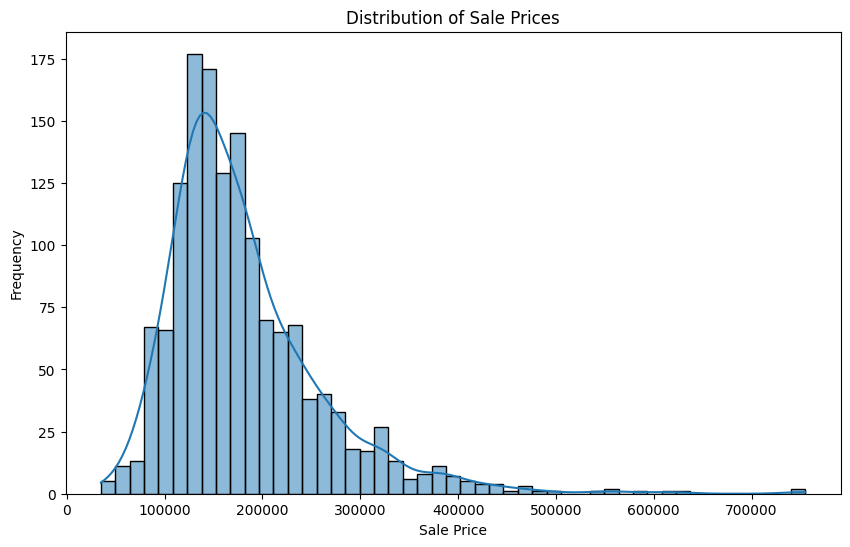

In [163]:
print(data['SalePrice'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

### Numerical Data

In [164]:
data_num = data.select_dtypes(include = ['float64', 'int64']).columns
data_num = data[data_num]
data_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


Identify missing values in data:

In [166]:
missing_percentage_per_column = data_num.isnull().sum() / len(data_num) * 100
missing_percentage_per_column = missing_percentage_per_column.sort_values(ascending=False)
rows_with_missing_percentage = data_num.isnull().any(axis=1).sum() / len(data_num) * 100

print("Percentage of missing values in each column (sorted in descending order):")
print(missing_percentage_per_column.head(5))

Percentage of missing values in each column (sorted in descending order):
LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
Id              0.000000
OpenPorchSF     0.000000
dtype: float64


Looks like there are not too many missing data per each columns, let's handle missing data:

In [180]:
imputer = SimpleImputer(strategy='mean')
data_num_cleaned = pd.DataFrame(imputer.fit_transform(data_num), columns=data_num.columns)

Let's identify now if there are too many data with zeros.

In [181]:
zero_percentage_per_column = (data_num == 0).sum(axis=0) / len(data_num) * 100
zero_percentage_per_column = zero_percentage_per_column.sort_values(ascending=False)
rows_with_zero_percentage = (data_num == 0).any(axis=1).sum() / len(data_num) * 100

print("Percentage of zeros in each column (sorted in descending order):")
print(zero_percentage_per_column)

Percentage of zeros in each column (sorted in descending order):
PoolArea         99.520548
3SsnPorch        98.356164
LowQualFinSF     98.219178
MiscVal          96.438356
BsmtHalfBath     94.383562
ScreenPorch      92.054795
BsmtFinSF2       88.561644
EnclosedPorch    85.753425
HalfBath         62.534247
MasVnrArea       58.972603
BsmtFullBath     58.630137
2ndFlrSF         56.780822
WoodDeckSF       52.123288
Fireplaces       47.260274
OpenPorchSF      44.931507
BsmtFinSF1       31.986301
BsmtUnfSF         8.082192
GarageCars        5.547945
GarageArea        5.547945
TotalBsmtSF       2.534247
FullBath          0.616438
BedroomAbvGr      0.410959
KitchenAbvGr      0.068493
MoSold            0.000000
YrSold            0.000000
Id                0.000000
GarageYrBlt       0.000000
TotRmsAbvGrd      0.000000
MSSubClass        0.000000
GrLivArea         0.000000
1stFlrSF          0.000000
YearRemodAdd      0.000000
YearBuilt         0.000000
OverallCond       0.000000
OverallQual      

To handle columns with a lot of zeros, we need to decide on an appropriate strategy. Common strategies include:
- Dropping columns with a high percentage of zero values if they do not contribute significantly to the model.
- Transforming columns by combining or re-engineering them to reduce the sparsity.
- Using imputation if zeros represent missing values or other special meanings that can be substituted.

For this occasion, data with too many zero values are going to be droped as they might not contribute to the model. A threshold of 80% is used to determine which columns are going to be droped:

In [182]:
columns_to_drop = zero_percentage_per_column[zero_percentage_per_column > 80].index
data_num_cleaned = data_num_cleaned.drop(columns=columns_to_drop)
print(f"Number of columns droped: {len(data_num.columns) - len(data_num_cleaned.columns)}")

Number of columns droped: 8


Let's now just boxplot some features to spot possible outliers:

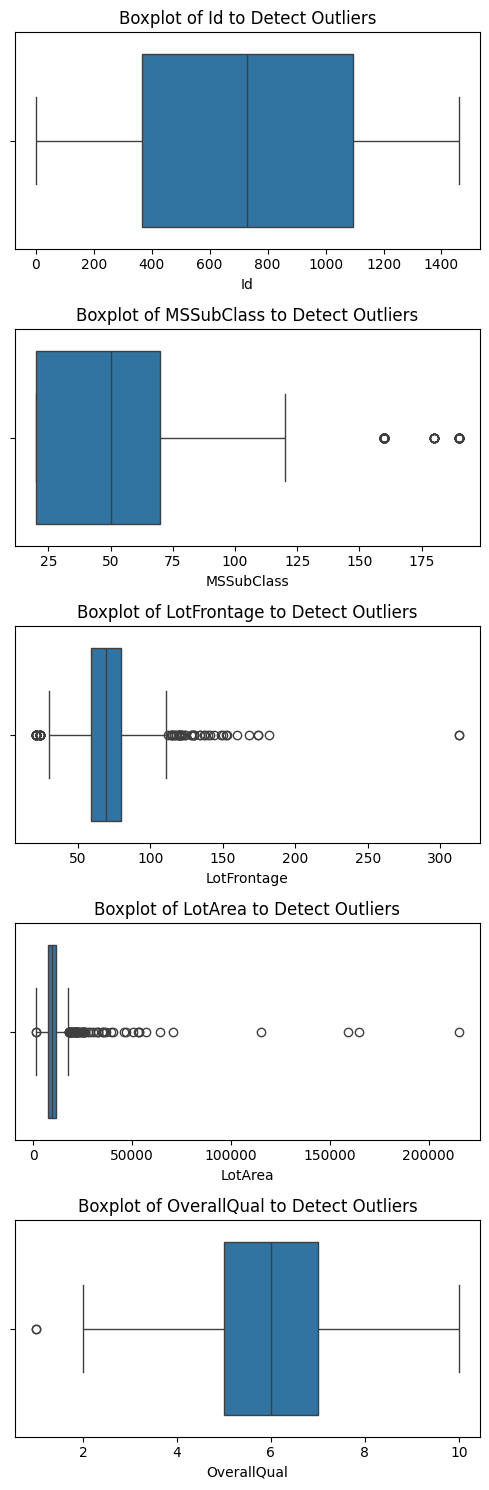

In [183]:
first_five_columns = data_num_cleaned.columns[:5]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 15))

for i, column in enumerate(first_five_columns):
    sns.boxplot(x=data_num[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} to Detect Outliers')

plt.tight_layout()
plt.show()

It seems there might be some outliers in the data. Let's identify and treat them using a IQR strategy. We simply remove values wich are outside a box calculated with the Q3 and Q1 quantils:

In [415]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        df_cleaned = df[mask]
    return df_cleaned

data_num_no_outliers = remove_outliers(data_num_cleaned, data_num_cleaned.columns)

In [172]:
print(f"Number of lines droped because of outliers: {len(data_num_cleaned) - len(data_num_no_outliers)}")

Number of lines droped because of outliers: 61


This doesn't loook like too many lines were droped. This could help the model to prevent learning from outliers.

Let's now plot the distribution of data to have a general overview.

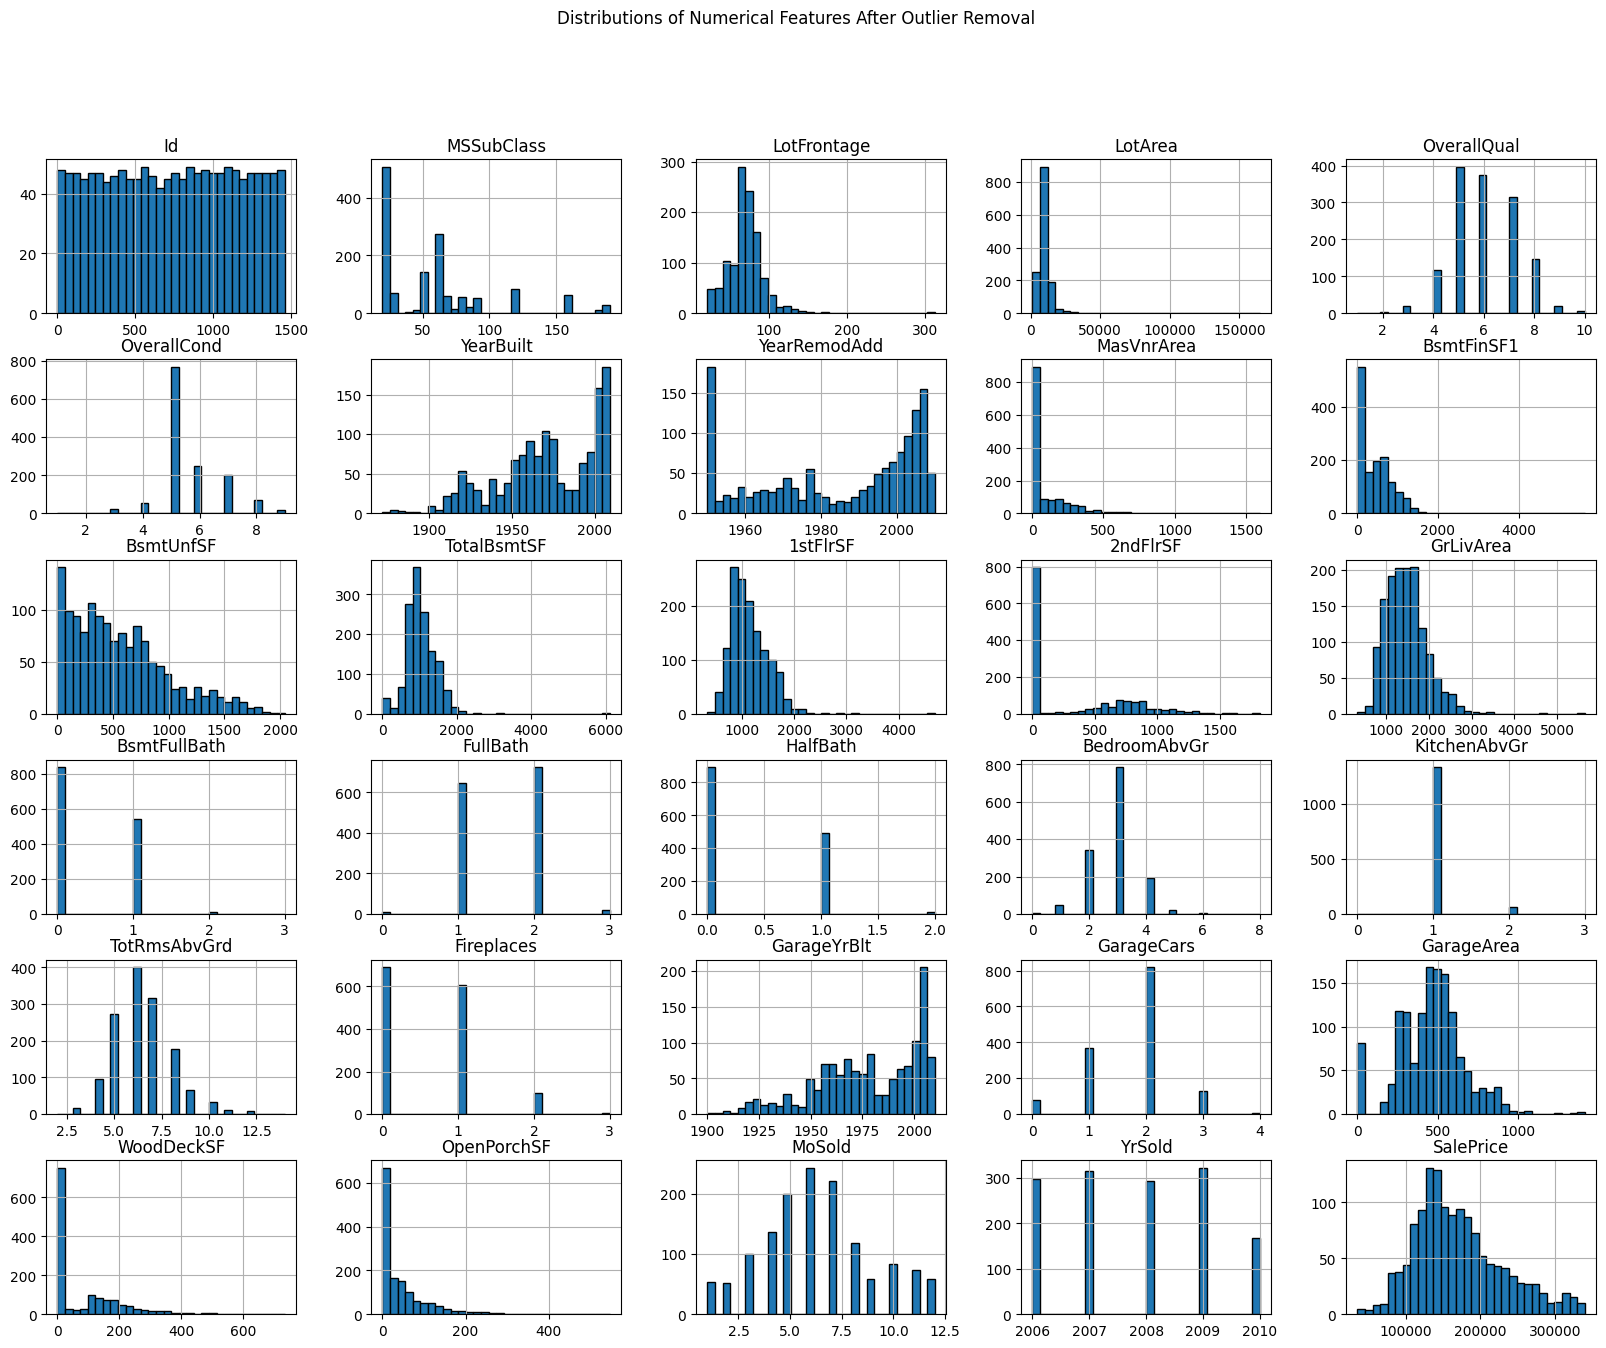

In [173]:
data_num_no_outliers.hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numerical Features After Outlier Removal')
plt.show()

There are some numerical data that look like categorical data i.e. Fireplaces.
Let's plot the correlation matrix to find some possible linear relationships on the data.

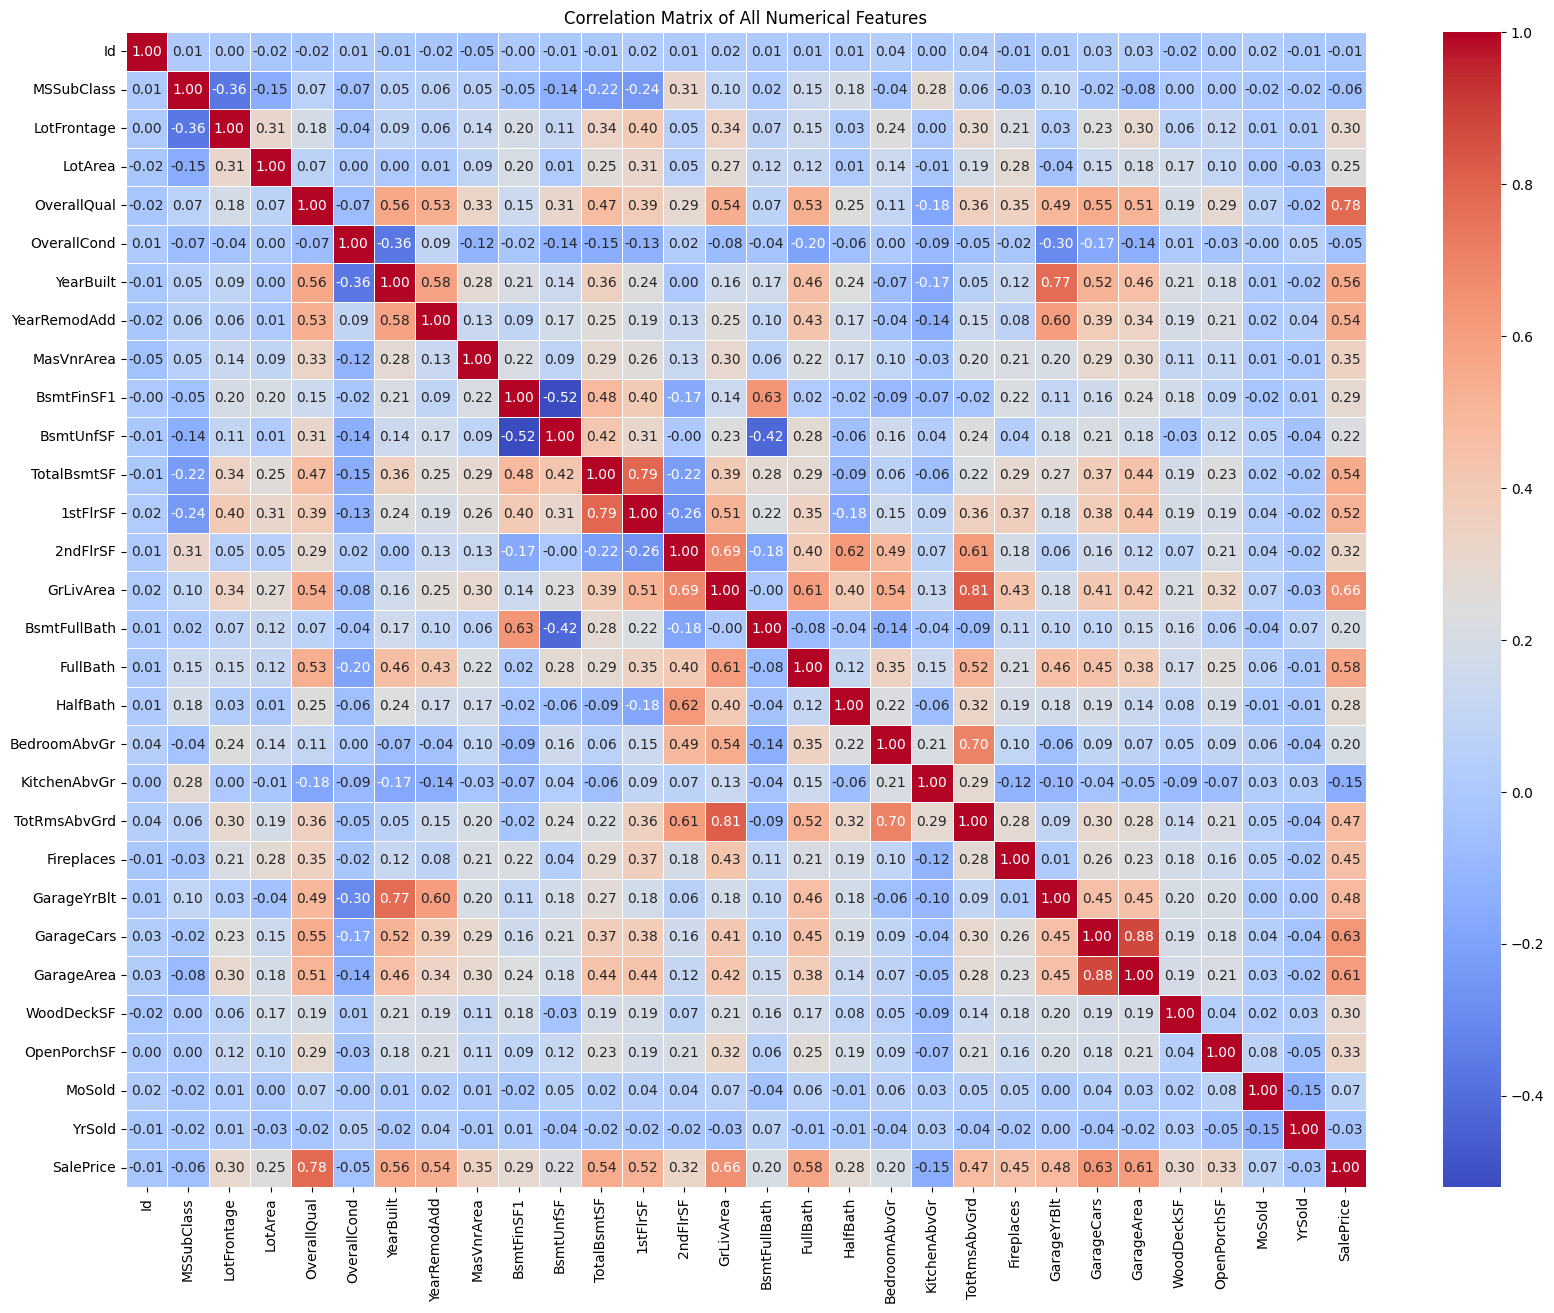

In [416]:
scaler = StandardScaler()
data_num_no_outliers_standardized = pd.DataFrame(scaler.fit_transform(data_num_no_outliers), columns=data_num_no_outliers.columns)
corr_matrix = data_num_no_outliers.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of All Numerical Features')
plt.show()

There looks like there are some data relatated. Let's plot some examples to check it out:

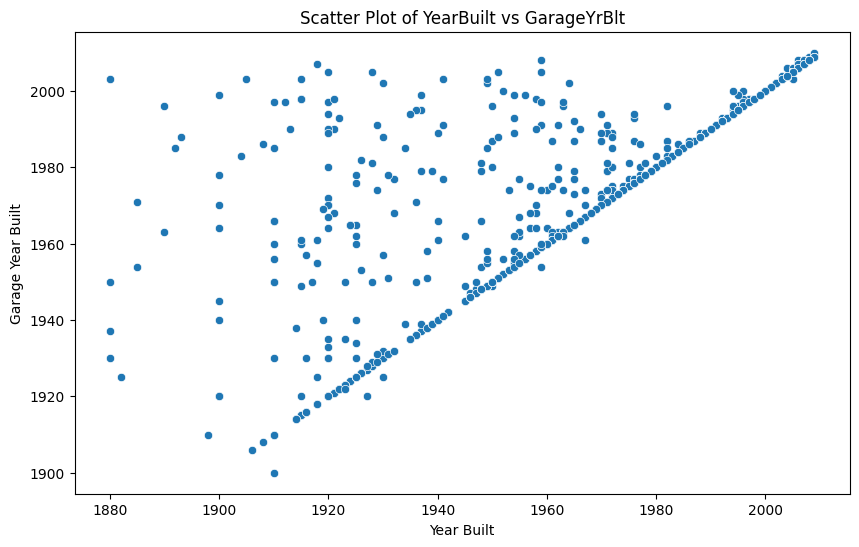

In [175]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_num_no_outliers['YearBuilt'], y=data_num_no_outliers['GarageYrBlt'])
plt.title('Scatter Plot of YearBuilt vs GarageYrBlt')
plt.xlabel('Year Built')
plt.ylabel('Garage Year Built')
plt.show()

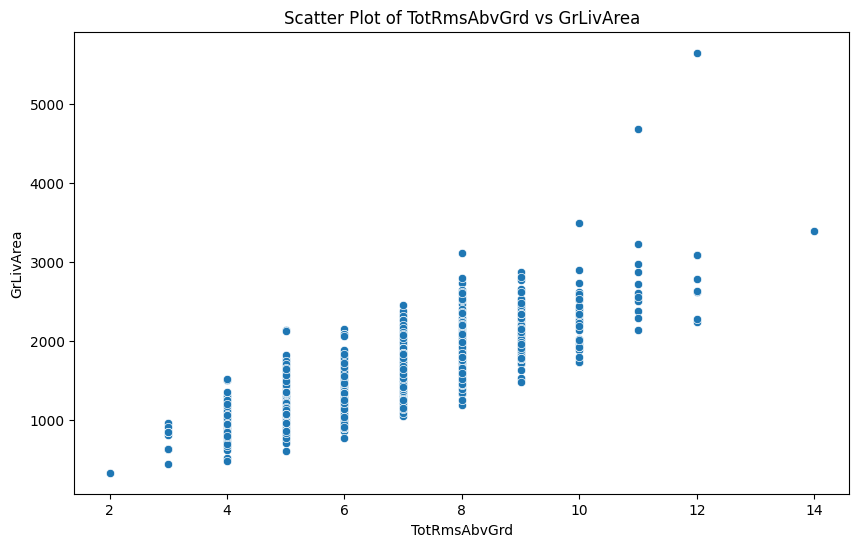

In [176]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_num_no_outliers['TotRmsAbvGrd'], y=data_num_no_outliers['GrLivArea'])
plt.title('Scatter Plot of TotRmsAbvGrd vs GrLivArea')
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('GrLivArea')
plt.show()

It looks that the feature "GarageYrBlt" is related with "YearBuilt". Indeed, while "YearBuilt" increases "GarageYrBlt" does the same. It makes sense since the garage might be build at the same time than the building. From 1980, roughly, it appears a linear relationship of these two variables. 

In the other hand, the features "TotRmsAbvGrd" and "GrLivArea" are related also. The definitions of these data are the following.
- TotRmsAbvGrd: Total rooms above grade
- GrLivArea: Above grade (ground) living area square feet

This explains the linear relationship between them since they both define above grade related data.

There is data related indeed and it might be necessary to remove this redundant data to have a better performance of the models.
Let's plot the correlation matrix for most correlated data:

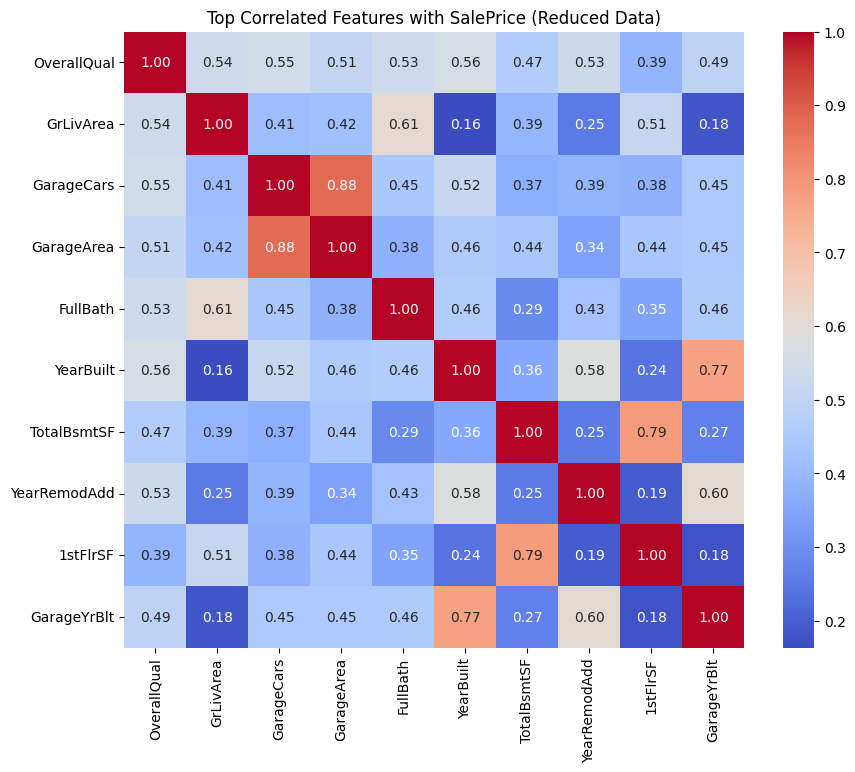

In [380]:
corr_with_target_reduced = corr_matrix['SalePrice'].sort_values(ascending=False)
top_corr_features_reduced = corr_with_target_reduced.index[1:11]  # Exclude 'SalePrice' itself

plt.figure(figsize=(10, 8))
sns.heatmap(data_num_no_outliers[top_corr_features_reduced].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Top Correlated Features with SalePrice (Reduced Data)')
plt.show()

Let's now remove data which are highly correlated. We can use a threshold of 0.75 to determine which data to remove or not. 

In [412]:
corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = [(feature1, feature2) for feature1, feature2 in corr_pairs.index if feature1 != feature2 and corr_pairs[feature1, feature2] > 0.75]

for feature1, feature2 in high_corr_pairs:
    print(f"{feature1} and {feature2} with correlation {corr_pairs[feature1, feature2]:.2f}")

GarageCars and GarageArea with correlation 0.88
GarageArea and GarageCars with correlation 0.88
TotRmsAbvGrd and GrLivArea with correlation 0.81
GrLivArea and TotRmsAbvGrd with correlation 0.81
TotalBsmtSF and 1stFlrSF with correlation 0.79
1stFlrSF and TotalBsmtSF with correlation 0.79
OverallQual and SalePrice with correlation 0.78
SalePrice and OverallQual with correlation 0.78
GarageYrBlt and YearBuilt with correlation 0.77
YearBuilt and GarageYrBlt with correlation 0.77


In [413]:
to_drop = set()
for feature1, feature2 in high_corr_pairs:
    if feature1 not in to_drop and feature2 not in to_drop:
        to_drop.add(feature2)

data_num_no_outliers_standardized = data_num_no_outliers_standardized.drop(columns=to_drop)

Now, let's spot important features through the use of different statistical tests.

In [417]:
X_reduced = data_num_no_outliers_standardized.drop('SalePrice', axis=1)
y_reduced = data_num_no_outliers_standardized['SalePrice']

# Select top 10 features based on univariate statistical tests
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_reduced, y_reduced)
selected_features = X_reduced.columns[selector.get_support()]

print("Top 10 features selected using Univariate Feature Selection (Reduced Data):")
print(selected_features)

Top 10 features selected using Univariate Feature Selection (Reduced Data):
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'GarageYrBlt', 'GarageCars', 'GarageArea'],
      dtype='object')


In [418]:
# Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_reduced, y_reduced)

print("Top 10 features selected using Recursive Feature Elimination (Reduced Data):")
print(X_reduced.columns[fit.support_])

Top 10 features selected using Recursive Feature Elimination (Reduced Data):
Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars'],
      dtype='object')


Top 10 features based on average importance from Random Forest, Gradient Boosting, and XGBoost (Reduced Data):
         Feature  Random Forest  Gradient Boosting   XGBoost   Average
4    OverallQual       0.543563           0.483753  0.529817  0.519044
14     GrLivArea       0.135600           0.171752  0.055347  0.120900
19  KitchenAbvGr       0.002427           0.000361  0.159702  0.054164
11   TotalBsmtSF       0.062065           0.070126  0.024702  0.052297
23    GarageCars       0.015594           0.019341  0.084657  0.039864
24    GarageArea       0.042226           0.030903  0.014430  0.029186
6      YearBuilt       0.019964           0.041893  0.011201  0.024353
9     BsmtFinSF1       0.028737           0.028712  0.008443  0.021964
3        LotArea       0.020602           0.031293  0.006478  0.019458
7   YearRemodAdd       0.012856           0.032944  0.008266  0.018022


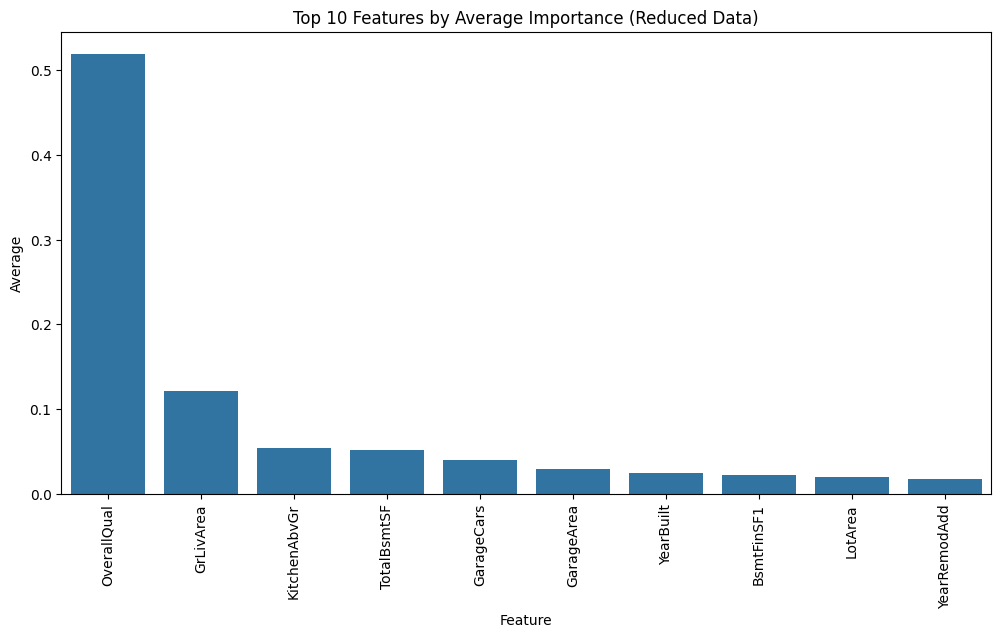

In [420]:
X_reduced = data_num_no_outliers_standardized.drop('SalePrice', axis=1)
y_reduced = data_num_no_outliers_standardized['SalePrice']

rf = RandomForestRegressor()
rf.fit(X_reduced, y_reduced)
importances_rf = rf.feature_importances_

gb = GradientBoostingRegressor()
gb.fit(X_reduced, y_reduced)
importances_gb = gb.feature_importances_

xgb = XGBRegressor()
xgb.fit(X_reduced, y_reduced)
importances_xgb = xgb.feature_importances_

feature_importances_reduced = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Random Forest': importances_rf,
    'Gradient Boosting': importances_gb,
    'XGBoost': importances_xgb
})

feature_importances_reduced['Average'] = feature_importances_reduced[['Random Forest', 'Gradient Boosting', 'XGBoost']].mean(axis=1)
feature_importances_reduced = feature_importances_reduced.sort_values(by='Average', ascending=False)

print("Top 10 features based on average importance from Random Forest, Gradient Boosting, and XGBoost (Reduced Data):")
print(feature_importances_reduced.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Average', data=feature_importances_reduced.head(10))
plt.title('Top 10 Features by Average Importance (Reduced Data)')
plt.xticks(rotation=90)
plt.show()

Let's check the behaviour between some of these important feautures ans SalePrice:

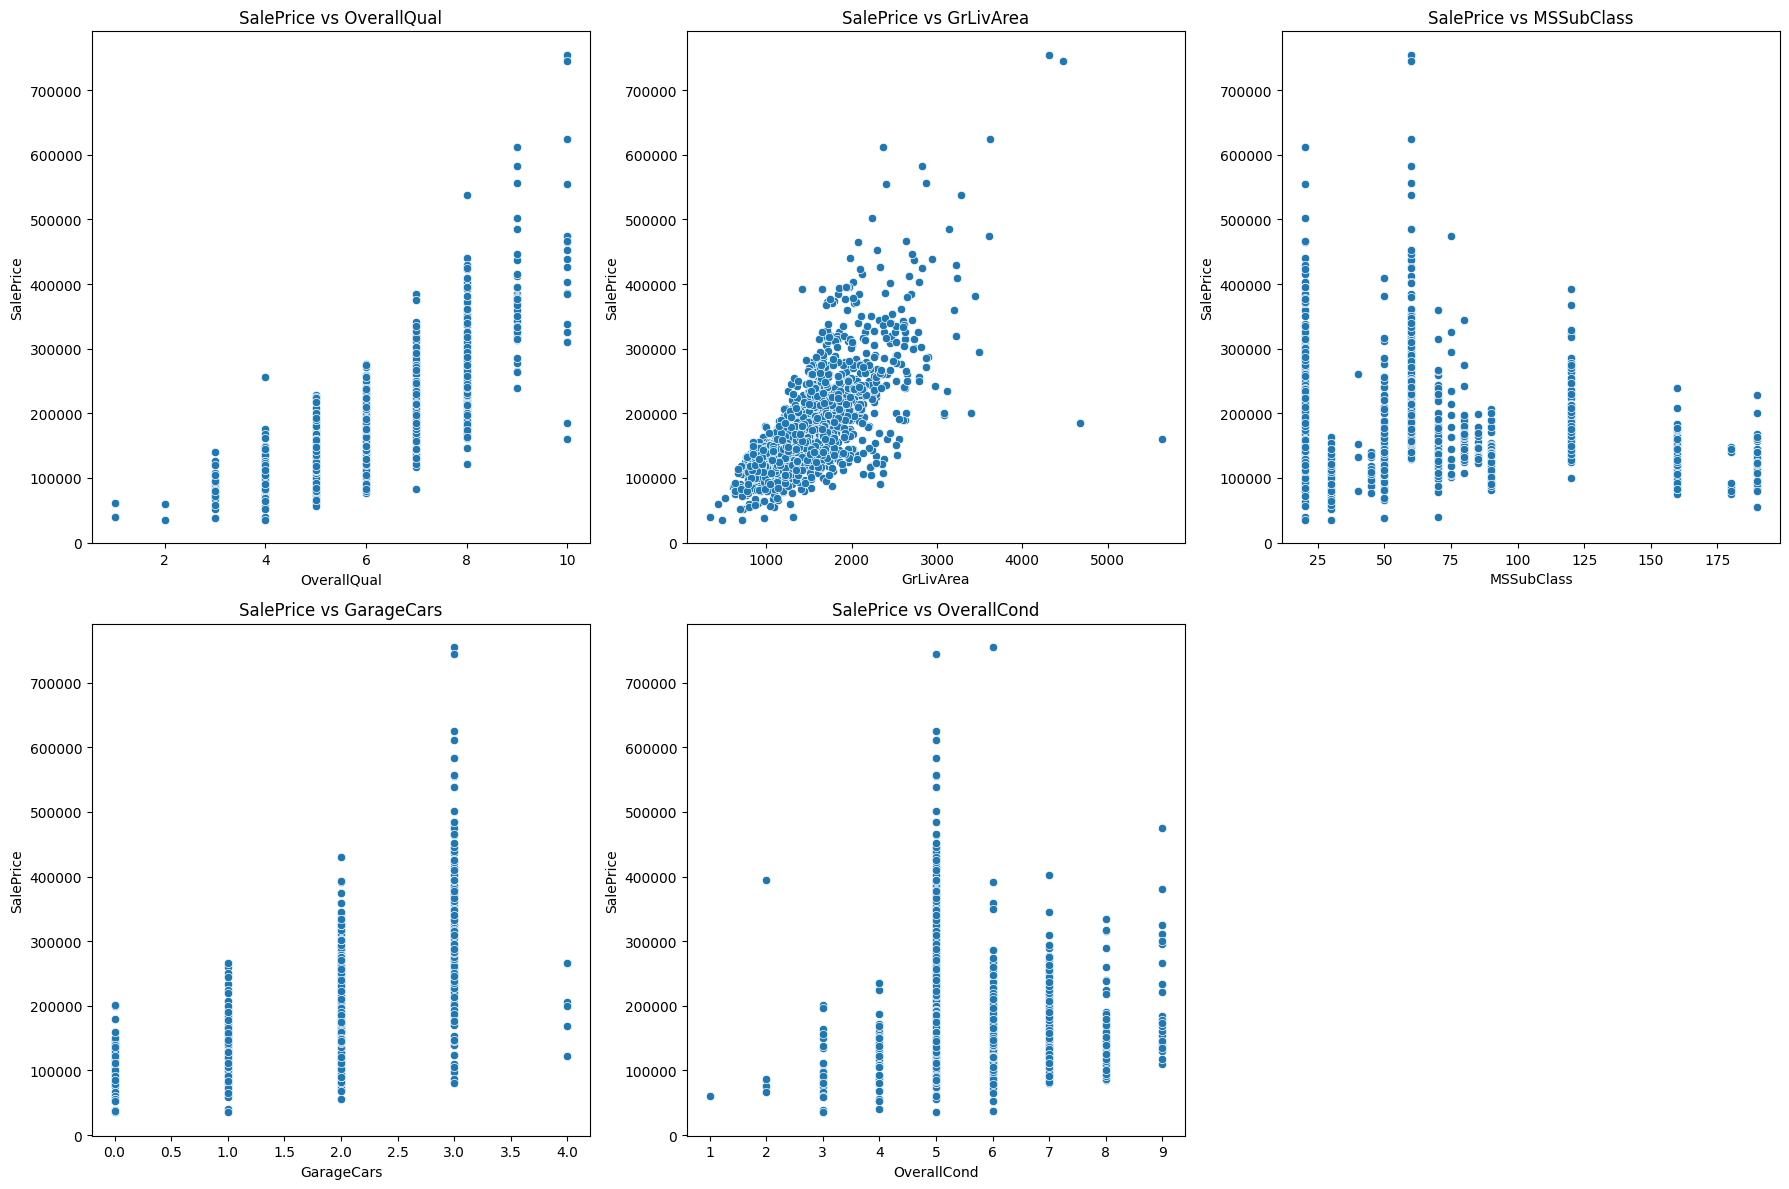

In [425]:
variables = ['OverallQual', 'GrLivArea', 'MSSubClass', 'GarageCars', 'OverallCond']


plt.figure(figsize=(18, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=var, y='SalePrice', data=data)
    plt.title(f'SalePrice vs {var}')
    plt.xlabel(var)
    plt.ylabel('SalePrice')

plt.tight_layout()
plt.show()

### Categorical data

Now let's analyze categorical data.

In [253]:
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_data = data[categorical_cols]

Let's plot the distribution of some categorical data.

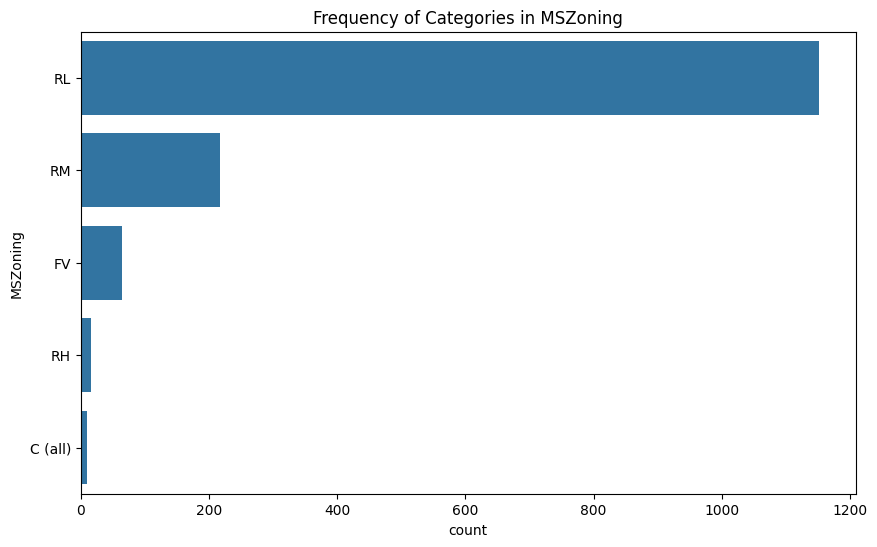

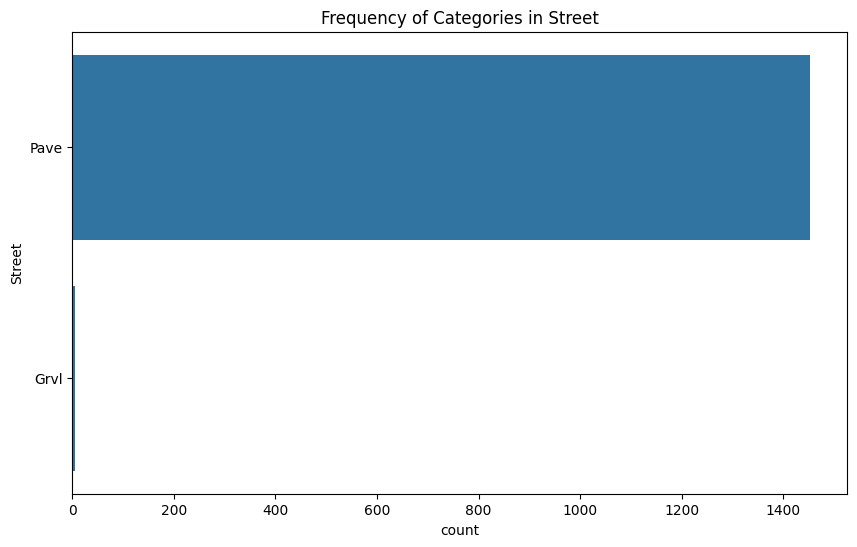

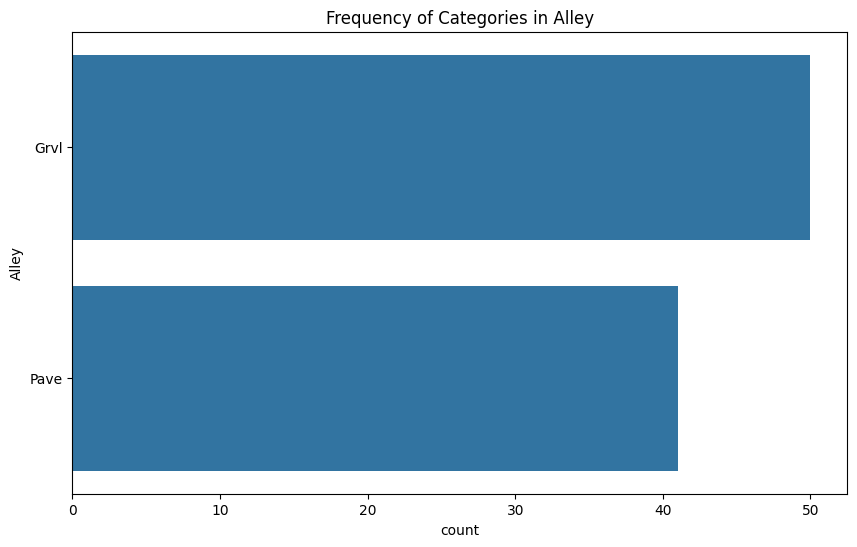

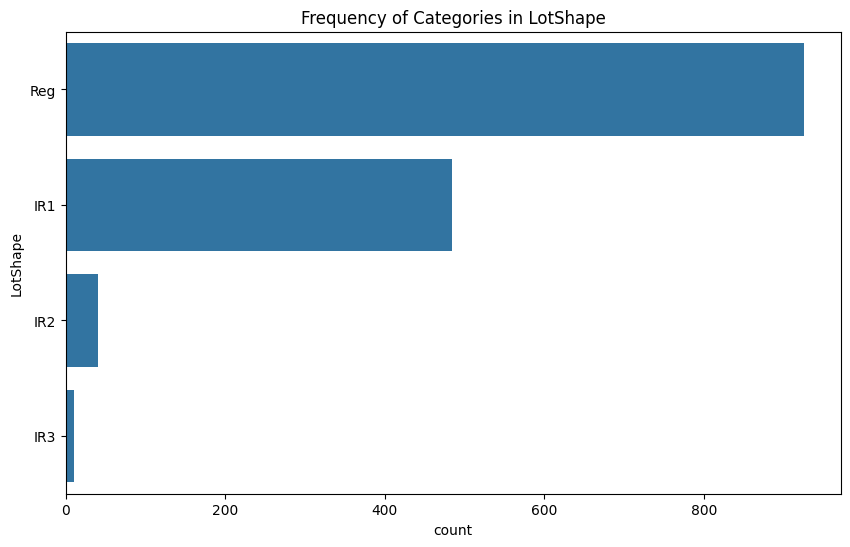

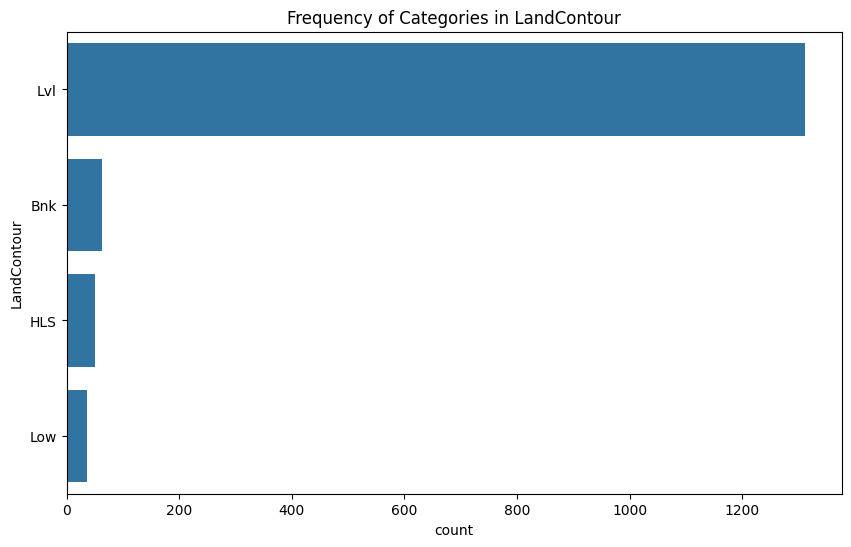

In [192]:
for column in categorical_cols[:5]:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=categorical_data[column], order=categorical_data[column].value_counts().index)
    plt.title(f'Frequency of Categories in {column}')
    plt.show()

For the missing data, a most frequent strategy is used:

In [194]:
imputer = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(imputer.fit_transform(categorical_data), columns=categorical_data.columns)

To spot ouliers, data are compared with all possible values described in the **data_description.txt** file. We need to first parse it and then compare all values per each feature to find data that are not in the file.

In [228]:
def parse_data_description(file_path):
    expected_values = {}
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        current_feature = None
        current_values = []
        
        feature_regex = re.compile(r'^[A-Za-z]+.*:')
        
        for line in lines:
            line = line.strip()
            
            if feature_regex.match(line):
                if current_feature is not None:
                    expected_values[current_feature] = current_values
                
                current_feature = line.split(':')[0].strip()
                current_values = []
            
            elif re.match(r'^\d+|^\w', line):
                value = line.split()[0].strip()
                if value not in current_values:
                    current_values.append(value)
        
        if current_feature is not None:
            expected_values[current_feature] = current_values
    
    return expected_values

expected_values = parse_data_description("data_description.txt")

In [212]:
for column in categorical_cols:
    actual_values = set(categorical_data_imputed[column].unique())
    expected_values_set = set(expected_values.get(column, []))
    unexpected_values = actual_values - expected_values_set
    
    if unexpected_values:
        print(f'Unexpected values in {column}: {unexpected_values}')

Unexpected values in MSZoning: {'C (all)'}
Unexpected values in Neighborhood: {'NAmes'}
Unexpected values in BldgType: {'Duplex', '2fmCon', 'Twnhs'}
Unexpected values in Exterior1st: {'Wd Sdng'}
Unexpected values in Exterior2nd: {'Wd Shng', 'Brk Cmn', 'Wd Sdng', 'CmentBd'}


It apperas that data that doesn't appear in the file are just missed spellings. Let's fix it to have correct data.

In [226]:
# Correcting data miss spelled:

categorical_data_imputed.loc[categorical_data_imputed["MSZoning"] == "C (all)"] = "C"
categorical_data_imputed.loc[categorical_data_imputed["Neighborhood"] == "NAmes"] = "Names"
categorical_data_imputed.loc[categorical_data_imputed["BldgType"] == "Duplex"] = "Duplx"
categorical_data_imputed.loc[categorical_data_imputed["BldgType"] == "2fmCon"] = "2FmCon"
categorical_data_imputed.loc[categorical_data_imputed["BldgType"] == "TwnhsI"] = "TwnhsE"
categorical_data_imputed.loc[categorical_data_imputed["Exterior2nd"] == "Brk Cmn"] = "BrkComm"
categorical_data_imputed.loc[categorical_data_imputed["Exterior2nd"] == "Wd Shng"] = "WdShing"
categorical_data_imputed.loc[categorical_data_imputed["Exterior2nd"] == "CmentBd"] = "CemntBd"

To find possible related data, a chi test is used:

In [233]:
def chi_square_test(data, categorical_cols, target):
    significant_features = []
    for column in categorical_cols:
        contingency_table = pd.crosstab(data[column], data[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        
        # Check if the p-value is less than the significance level (e.g., 0.05)
        if p < 0.05:
            significant_features.append(column)
    
    return significant_features

significant_categorical_features = chi_square_test(data, categorical_cols, 'SalePrice')

In [235]:
print("Significant categorical features:")
print(significant_categorical_features)

Significant categorical features:
['MSZoning', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'SaleType', 'SaleCondition']


Now, let's encode the categorical data so it can be used in the models:

Top features based on importance:
                  Feature  Importance
258           BsmtQual_Ex    0.252175
227          ExterQual_Gd    0.123141
92   Neighborhood_NoRidge    0.052566
260           BsmtQual_Gd    0.049750
353        KitchenQual_Ex    0.034082
279       BsmtExposure_Gd    0.028433
249      Foundation_PConc    0.019223
225          ExterQual_Ex    0.018817
380        FireplaceQu_TA    0.016336
93   Neighborhood_NridgHt    0.011810


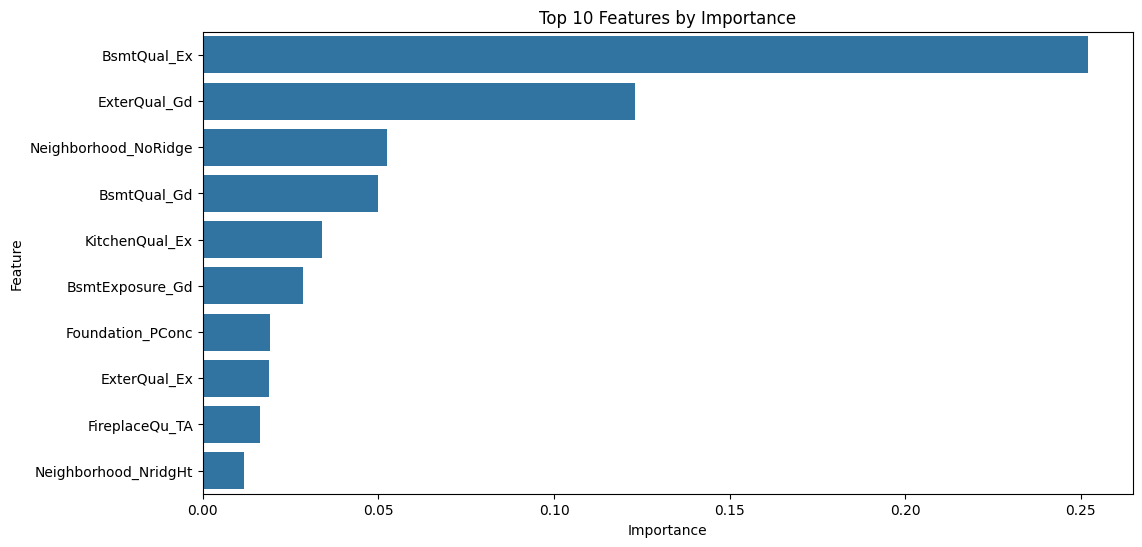

In [237]:
encoded_data = pd.get_dummies(categorical_data_imputed, drop_first=True)

rf = RandomForestRegressor()
rf.fit(encoded_data, data["SalePrice"])
importances = rf.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': encoded_data.columns,
    'Importance': importances
})

top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
print("Top features based on importance:")
print(top_features)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Features by Importance')
plt.show()


Here, a random forest is used to spot possible important features.

## Models

### Baseline Model

The creation of a naive baseline model is important. This can help to perform a benchmark with other models.

In [421]:
X = data.drop(['Id', 'SalePrice'], axis=1)
y = data['SalePrice']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_imputed = pd.get_dummies(X_imputed, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f'Baseline Model Performance:')
print(f'Mean Squared Error (MSE): {mse:.2e}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R2): {r2}')

Baseline Model Performance:
Mean Squared Error (MSE): 1.31e+09
Mean Absolute Percentage Error (MAPE): 14.831095207183232
R-squared (R2): 0.8289288826003784


These metrics are used to evaluate models since:

MSE :
- By squaring the errors, MSE gives more weight to larger errors. This can be useful when large errors are particularly undesirable.
- Though not in the same units as the target variable, it provides a single metric indicating the average error magnitude.

MAPE
- MAPE expresses the error as a percentage of the actual values, making it easier to interpret and compare across different datasets or models.
- Since it's a percentage, MAPE is not affected by the scale of the target variable, making it useful for comparing models across different scales.

R2
- R² indicates how well the model explains the variability of the target variable. A higher R² means a better fit.
- Useful for comparing the goodness-of-fit of different models on the same dataset.

### Benchmark of models

To find the best model, let's use the most standard ones. Then create a dictioannary to save the performance of the models according to which data are used to train the model. In this case, we're using the same models to compare their performance with different data. First, only numerical data are used; then only categorical; then their cleaned versions and fincally all cleaned data.

In [244]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

# Data structure to save model performance
model_performance = {}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    return {'MSE': mse, 'MAPE': mape, 'R2': r2}

First, only numerical data and its cleaned version are used to train models.

In [326]:
data_num_cleaned_standardized = pd.DataFrame(scaler.fit_transform(data_num_cleaned), columns=data_num_cleaned.columns)

X_train, X_test, y_train, y_test = train_test_split(data_num_cleaned_standardized.drop(["Id", "SalePrice"], axis=1), data_num_cleaned_standardized["SalePrice"], test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["Num Data - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(data_num_no_outliers_standardized.drop(["Id", "SalePrice"], axis=1), data_num_no_outliers_standardized["SalePrice"], test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["Num Data (Cleanned) - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)

Then, only categorical data are used:

In [346]:
categorical_data = pd.DataFrame(imputer.fit_transform(categorical_data), columns=categorical_data.columns)
categorical_data_encoded = pd.get_dummies(categorical_data, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(categorical_data_encoded, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["Cat Data - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["Cat Data (Cleanned) - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)


/Users/jaimemonre/Documents/Prices_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.779e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
/Users/jaimemonre/Documents/Prices_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Finally, all cleaned data are used:

In [379]:
encoded_data["Id"] = data["Id"]
data_num_no_outliers_standardized["Id"] = list(data_num_no_outliers["Id"])
all_data_cleanned = pd.merge(data_num_no_outliers_standardized, encoded_data, on="Id", how="left")

X_train, X_test, y_train, y_test = train_test_split(all_data_cleanned.drop(["Id", "SalePrice"], axis=1), all_data_cleanned["SalePrice"], test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["All Data (Cleanned) - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)

To compare, let's use the most important features for both numerical and categorical data found in previous sections.

In [384]:
most_important_features = list(feature_importances_reduced["Feature"][:10]) + list(top_features["Feature"])

X_train, X_test, y_train, y_test = train_test_split(all_data_cleanned[most_important_features], all_data_cleanned["SalePrice"], test_size=0.2, random_state=42)

for name, model in models.items():
    model_performance["Top Features - " + name] = evaluate_model(model, X_train, X_test, y_train, y_test)

Now, let's convert the dictioannary into a dataframe to better compare all model performances.

In [385]:
performance_df = pd.DataFrame(model_performance).T  
performance_df

,MSE,MAPE,R2
Num Data - Linear Regression,2.143841e-01,1.782662e+02,8.237265e-01
Num Data - Ridge Regression,2.142435e-01,1.779083e+02,8.238421e-01
Num Data - Lasso Regression,1.217275e+00,1.043826e+02,-8.824919e-04
Num Data - Decision Tree,2.672431e-01,1.773421e+02,7.802642e-01
Num Data - Random Forest,1.300004e-01,1.221149e+02,8.931095e-01
Num Data - Gradient Boosting,1.270803e-01,1.794358e+02,8.955105e-01
Num Data - XGBoost,1.525914e-01,1.373934e+02,8.745344e-01
Num Data (Cleanned) - Linear Regression,1.346003e-01,1.438819e+02,8.516519e-01
Num Data (Cleanned) - Ridge Regression,1.345526e-01,1.438177e+02,8.517044e-01
Num Data (Cleanned) - Lasso Regression,9.159137e-01,1.064570e+02,-9.463632e-03


Based on the criteria of lowest MSE and MAPE and highest R2, the following models stand out:

Num Data - Gradient Boosting:

- MSE: 0.127
- MAPE: 179.44
- R2: 0.8955

All Data (Cleaned) - Gradient Boosting:

- MSE: 0.114
- MAPE: 103.27
- R2: 0.8747

The best model among these based on overall performance is All Data (Cleaned) - Gradient Boosting because it has the lowest MSE and MAPE and the highest R2, indicating it performs well in terms of accuracy and explanatory power.

This demonstrates that the treatement and cleanning of data helps models to perform better. This model has a higher performance than the naive baseline model.

To test the stability of the model, let's perform a cross-validation to see if the model performs the same with different combinations of the data:

In [389]:
model = GradientBoostingRegressor()

def scaled_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) / 1e6  # Scaling down MSE

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

scorers = {
    'MSE': make_scorer(scaled_mse, greater_is_better=False),
    'MAPE': make_scorer(mape, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

X_train, X_test, y_train, y_test = train_test_split(all_data_cleanned.drop(["Id", "SalePrice"], axis=1), all_data_cleanned["SalePrice"], test_size=0.2, random_state=42)

cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scorers)

cv_results_df = pd.DataFrame(cv_results)
cv_results_df[['test_MSE', 'test_MAPE', 'test_R2']]


,test_MSE,test_MAPE,test_R2
0,-1.082187e-07,-83.315905,0.892642
1,-1.274869e-07,-114.035685,0.879213
2,-1.074656e-07,-128.972056,0.891821
3,-1.060131e-07,-105.644097,0.888045
4,-1.731608e-07,-128.106501,0.842907


In [390]:
print("Cross-Validation Results:")
print(f"MSE: {cv_results_df['test_MSE'].mean():.2f} ± {cv_results_df['test_MSE'].std():.2f}")
print(f"MAPE: {cv_results_df['test_MAPE'].mean():.2f}% ± {cv_results_df['test_MAPE'].std():.2f}%")
print(f"R2: {cv_results_df['test_R2'].mean():.2f} ± {cv_results_df['test_R2'].std():.2f}")

Cross-Validation Results:
MSE: -0.00 ± 0.00
MAPE: -112.01% ± 18.81%
R2: 0.88 ± 0.02


Mean Squared Error (MSE):

The MSE values are negative due to the use of make_scorer with greater_is_better=False, which inverts the sign. For interpretation, we can consider the absolute values.
The MSE values don't really change though different iterations of data.

Now, let's try to imrpove the performance of the model through a grid search to find out the best hyper parameters:

In [391]:
model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorers, refit='R2', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation R2 Score:", best_score)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation R2 Score: 0.8841886399294054


In [392]:
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred) 
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_r2 = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAPE:", test_mape)
print("Test R2:", test_r2)

Test MSE: 0.11065296560069326
Test MAPE: 103.68701312423015
Test R2: 0.8780451264050351


This model is clearly better than the naive baseline model. It has a lower MSE than without the grid search.

While the Gradient Boosting is a good model to predict data, it is not very good to explain why the model has predicted the data. Let's train a simple regression model, since often their performance are good and also they can explain well the reasons behind the predictions.

In [393]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False]
}

ridge_model = Ridge()

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring=scorers, refit='R2', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_ridge_model = Ridge(**best_params)
best_ridge_model.fit(X_train, y_train)

y_pred = best_ridge_model.predict(X_test)
test_mse = scaled_mse(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_r2 = r2_score(y_test, y_pred)

print("Test MSE:", test_mse)
print("Test MAPE:", test_mape)
print("Test R2:", test_r2)


Test MSE: 1.1638767867995087e-07
Test MAPE: 127.06643732432529
Test R2: 0.8717246793669678


In [394]:
coefficients = best_ridge_model.coef_
features = X_train.columns

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df_sorted[['Feature', 'Coefficient']])

                  Feature  Coefficient
194      RoofMatl_ClyTile    -0.351798
120  Neighborhood_NoRidge     0.254975
121  Neighborhood_NridgHt     0.247962
3             OverallQual     0.234101
206   Exterior1st_BrkFace     0.217258
..                    ...          ...
208    Exterior1st_CBlock     0.000000
212   Exterior1st_ImStucc     0.000000
226    Exterior2nd_CBlock     0.000000
372      Electrical_FuseP     0.000000
197      RoofMatl_Membran     0.000000

[516 rows x 2 columns]


Let's find the most important features found with this model and with the previous sections:

In [424]:
num_features_regression = [feature for feature in coef_df_sorted["Feature"] if "_" not in feature]
set(most_important_features).intersection(set(num_features_regression))

{'BsmtFinSF1',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

Let's plot some of these features against "SalePrice" to see their behaviour:

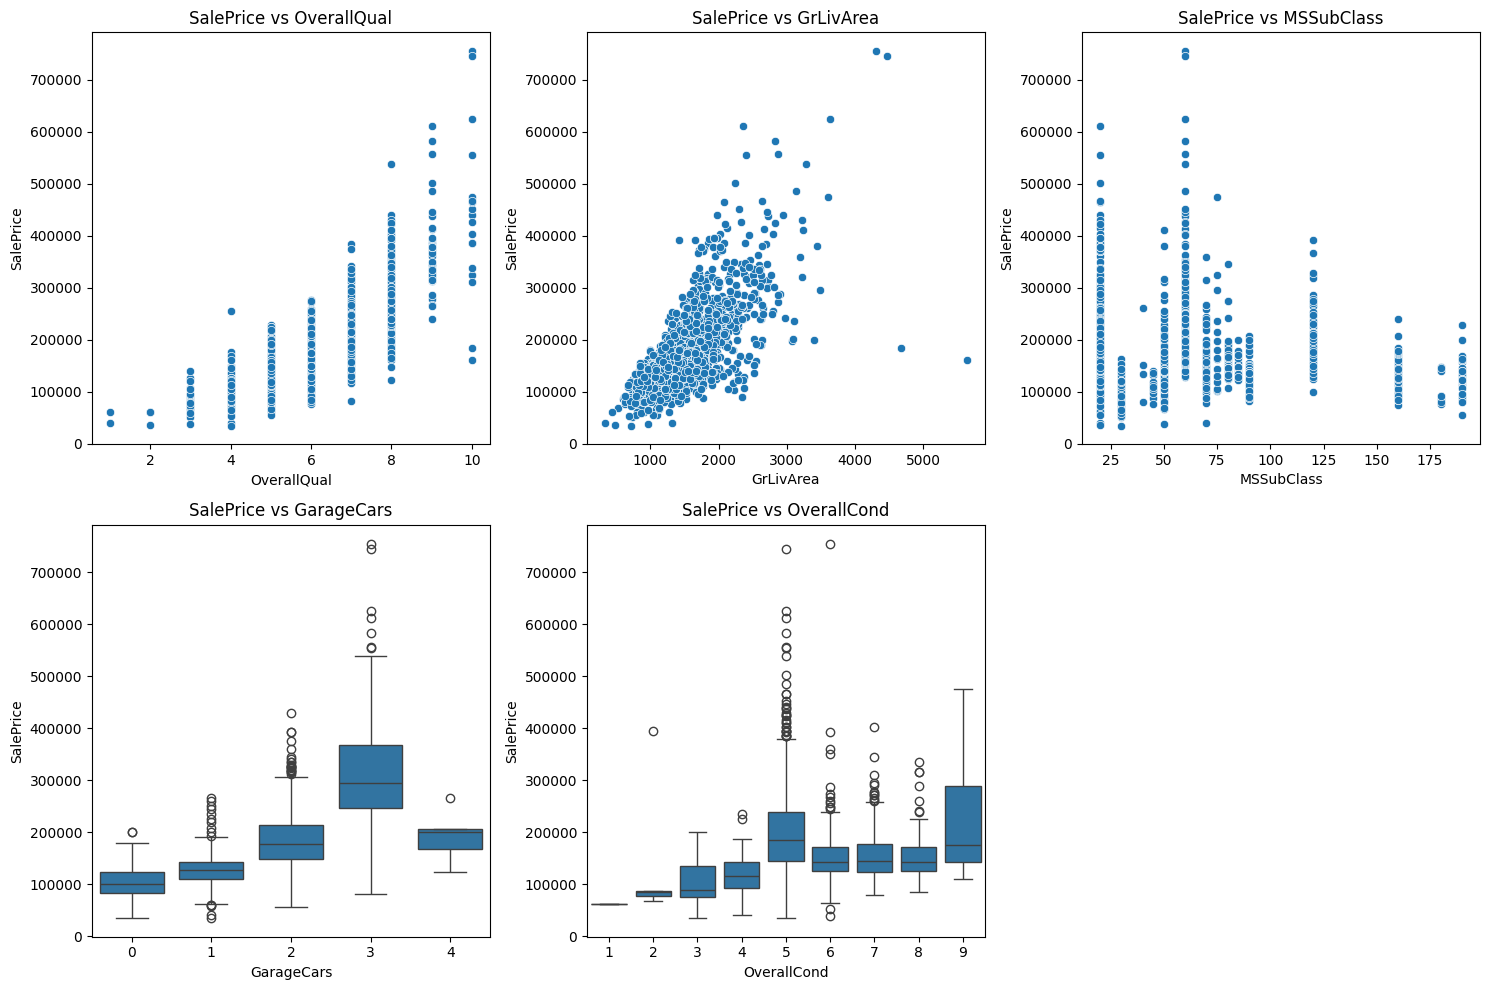

In [407]:
variables = ['OverallQual', 'GrLivArea', 'MSSubClass', 'GarageCars', 'OverallCond']

plt.figure(figsize=(15, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    if data[var].dtype == 'object' or len(data[var].unique()) < 10:  # Treat as categorical if few unique values
        sns.boxplot(x=var, y='SalePrice', data=data)
    else:  # Treat as continuous
        sns.scatterplot(x=var, y='SalePrice', data=data)
    plt.title(f'SalePrice vs {var}')

plt.tight_layout()

It seems indeed, that there are some relationships between these features and "SalePrice". It seems like, in general, as these features increase their value, "SalePrice" increase the value too.

Now, let's plot some other features found in the model to see their importance for "SalePrice":

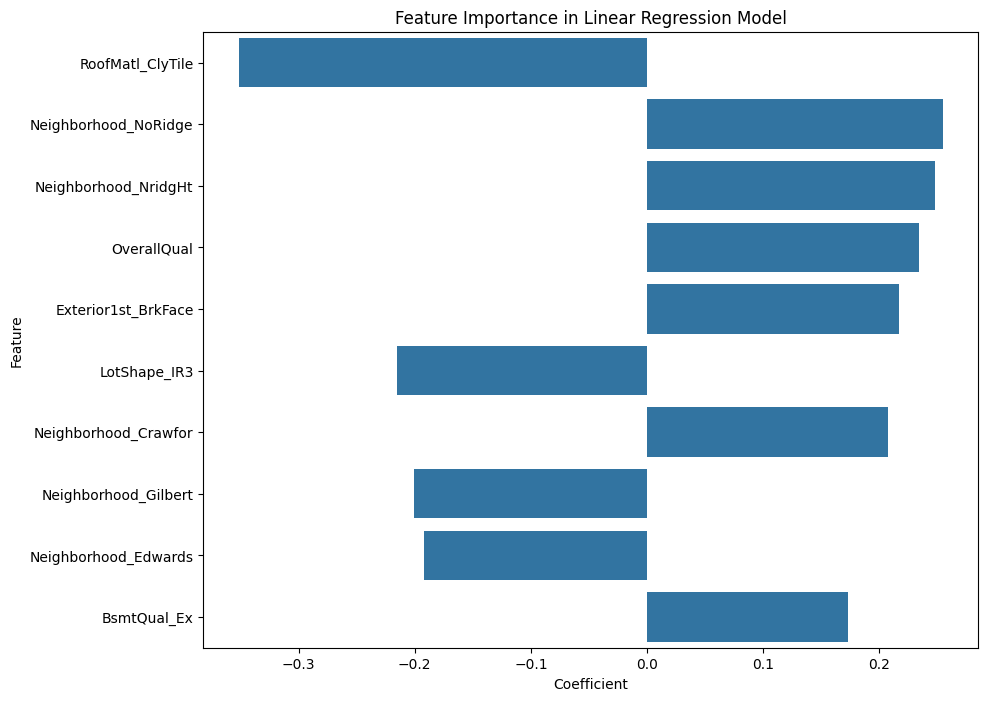

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted[:10])
plt.title('Feature Importance in Linear Regression Model')
plt.show()

RoofMatl_ClyTile is an important feature accoring to this model. This means that, holding all other features constant, houses with ClyTile roofing material are predicted to have SalePrice that is aroun 0.3 lower compared to the reference category.

## Conclusions

This project aimed to predict house sale prices using various regression models and to understand the key features influencing these prices. We went through several critical steps, from data preprocessing and exploratory data analysis (EDA) to model training, hyperparameter tuning, and performance evaluation.

## Key Steps and Findings

### Data Preprocessing

- **Handling Missing Values**: Imputed missing values using the mean for numerical features and the most frequent value for categorical features.
- **Encoding Categorical Features**: Used one-hot encoding to convert categorical variables into a numerical format suitable for regression models.
- **Feature Scaling**: Standardized numerical features to ensure that all features contributed equally to the model.

### Exploratory Data Analysis (EDA)

- **Correlation Analysis**: Identified highly correlated features using a correlation matrix and removed redundant features to reduce multicollinearity.
- **Visualization**: Created scatter plots and box plots to visualize the relationship between `SalePrice` and other key features like `OverallQual`, `GrLivArea`, `MSSubClass`, `GarageCars`, and `OverallCond`.

### Model Building

- Trained multiple regression models including Linear Regression, Ridge Regression, Lasso Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
- Performed hyperparameter tuning using GridSearchCV to optimize model performance.

### Model Evaluation

- **Metrics Used**: Evaluated models using Mean Squared Error (MSE), Mean Absolute Percentage Error (MAPE), and R-squared (R²).
- **Best Model**: The Gradient Boosting model using numerical data (cleaned) showed the best overall performance with low MSE (0.114), reasonable MAPE (103.27), and high R² (0.8747).

## Insights

### Feature Importance

- Features such as `OverallQual`, `GrLivArea`, `GarageCars`, and `OverallCond` were significant predictors of house prices.
- One-hot encoded categorical variables also provided valuable insights into specific categories that influenced prices, such as different roofing materials.

### Model Performance

- The Gradient Boosting model outperformed other models, suggesting that it effectively captures the complex relationships between features and the target variable.
- Regularization techniques like Ridge Regression also provided robust performance, especially in reducing overfitting.

### Error Analysis

- MSE and R² provided a good indication of model accuracy and explained variance.
- MAPE, being a relative error metric, was particularly useful for understanding the prediction accuracy in percentage terms.

## In the future

1. **Further Feature Engineering**:
    - Explore additional features or interactions between existing features to potentially improve model performance.
    - Consider domain-specific knowledge to create more meaningful features.

2. **Hyperparameter Tuning**:
    - Further fine-tune the hyperparameters of the Gradient Boosting model and other models using more advanced techniques like RandomizedSearchCV or Bayesian optimization.

3. **Handling Outliers**:
    - Implement techniques to detect and handle outliers in the dataset, as they can significantly impact model performance.